In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

In [2]:
engine1 = pd.read_csv("UIPA.HMD8310H.Engine1.csv")
engine1["battery_only"] = engine1["dIECSPoweredByBatteryOnlyPilotTrip"].fillna(0).astype(int)
engine2 = pd.read_csv("UIPA.HMD8310H.Engine2.csv")

merged_df = pd.merge(engine1[["aIEngineLoad", "time", "battery_only"]], engine2[["aIEngineLoad", "time"]], on='time', how='inner')
merged_df["total_load"] = merged_df["aIEngineLoad_x"] + merged_df["aIEngineLoad_y"]

/tmp/ipykernel_170260/1076848645.py:1: DtypeWarning: Columns (152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,38

In [3]:
mgo = pd.read_csv("RemoteLevelThing_HMD8310.csv")
mgo["total_vol"] = mgo["MGO_STOR_TK_C_CALC_VOL"] + mgo["MGO_STOR_TK_S_CALC_VOL"] + mgo["NO1_MGO_SERV_TK_CALC_VOL"] + mgo["NO2_MGO_SERV_TK_CALC_VOL"]

/tmp/ipykernel_170260/3850218066.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  mgo = pd.read_csv("RemoteLevelThing_HMD8310.csv")


In [4]:
engine_and_fuel_df = pd.merge(merged_df, mgo[["total_vol", "time"]], on='time', how='inner')
engine_and_fuel_df.shape

(107225, 6)

In [5]:
battery_data = pd.read_csv("EP_Battery.Thing_HMD8310.csv")

/tmp/ipykernel_170260/4261599124.py:1: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  battery_data = pd.read_csv("EP_Battery.Thing_HMD8310.csv")


In [6]:
battery_columns_to_use = ["AVG_PACK_SOC", "Current", "Voltage", "time"]
for i in range(1, 8):
    battery_columns_to_use.append(f"PACK{i}_CRIDATA_BATT_VOL")
    battery_columns_to_use.append(f"PACK{i}_CRIDATA_CURR")
    battery_columns_to_use.append(f"PACK{i}_CRIDATA_SOC")

In [7]:
final_df = pd.merge(engine_and_fuel_df, battery_data[battery_columns_to_use], on='time', how='inner')
final_df.shape

(107225, 30)

# Battery SOC reduction

In [8]:
# Lee Ja Yun's data
good_discharge_data = pd.read_excel("discharge_lee_ja_yun.xls")
good_discharge_data.shape

(1969, 7)

In [9]:
end_indexes = good_discharge_data.loc[good_discharge_data["index"].diff()>1, "index"].index
segments = []
start_index = 0
for end_index in end_indexes:
    try:
        segment = good_discharge_data.loc[start_index:end_index].copy()
        segment["SOC_diff"] = segment["AvgSOC"].diff()
        segment.loc[:(segment.index[-2]), "SOC_diff"] = segment.iloc[1:]["SOC_diff"].values
        segment.drop(segment.head(1).index, inplace=True)
        segment.drop(segment.tail(1).index, inplace=True)
        drop_idx = segment[(segment["SOC_diff"]>0) | (segment["SOC_diff"]<-3)].index
        segment.drop(drop_idx, inplace=True)
        segments.append(segment)
        start_index = end_index+1
    except:
        pass

In [10]:
dataset = pd.concat(segments)
dataset.reset_index(drop=True, inplace=True)
round_power = 100000
dataset['rounded_power'] = (dataset['Power'] / round_power).round() * round_power
round_voltage = 10
dataset['rounded_voltage'] = (dataset['Voltage'] / round_voltage).round() * round_voltage
print(dataset.shape)

(1556, 10)


/tmp/ipykernel_170260/2963372017.py:16: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in legend1.legendHandles:
/tmp/ipykernel_170260/2963372017.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in legend2.legendHandles:
/tmp/ipykernel_170260/2963372017.py:32: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in legend1.legendHandles:
/tmp/ipykernel_170260/2963372017.py:34: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in legend2.legendHandles:


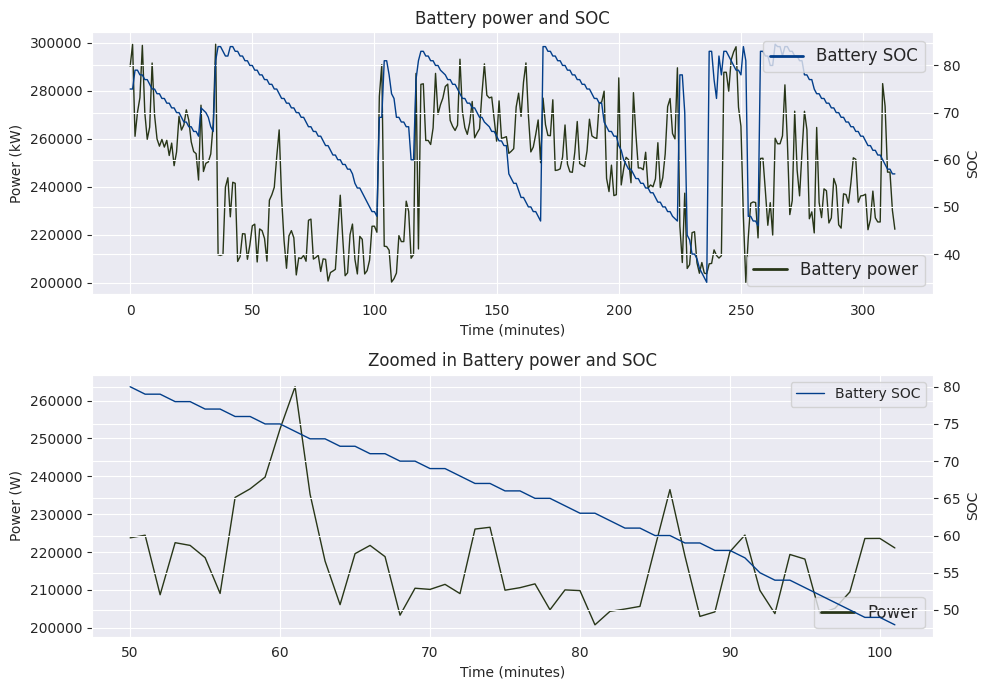

In [11]:
filtered_data = dataset[(dataset["Power"]<300000) & (dataset["Power"]>200000)].copy()
filtered_data.reset_index(drop=True, inplace=True)

sns.set_style('darkgrid')
fig, axes = plt.subplots(2, 1, figsize=(10, 7))
sns.lineplot(filtered_data["Power"], label='Battery power', alpha=1, linewidth=1, color='#283618', ax=axes[0])
axes[0].set_title('Battery power and SOC')
axes[0].set_xlabel('Time (minutes)')  # Setting X-axis label
axes[0].set_ylabel('Power (kW)')  # Setting Y-axis label
ax0_twin = axes[0].twinx()
ax0_twin.set_ylabel('SOC')  # Setting Y-axis label
sns.lineplot(filtered_data["AvgSOC"], label='Battery SOC', alpha=1, linewidth=1, color='#023E8A', ax=ax0_twin)
axes[0].legend()
legend1 = axes[0].legend(loc='lower right', fontsize='large')  # Legend with increased size
legend2 = ax0_twin.legend(loc='upper right', fontsize='large')  # Legend with increased size
for legobj in legend1.legendHandles:
    legobj.set_linewidth(2.0)  # Increase the linewidth in the legend
for legobj in legend2.legendHandles:
    legobj.set_linewidth(2.0)  # Increase the linewidth in the legend

sns.lineplot(filtered_data["Power"][50:102], label='Power', alpha=1, linewidth=1, color='#283618', ax=axes[1])
axes[1].set_title('Zoomed in Battery power and SOC')
axes[1].set_xlabel('Time (minutes)')  # Setting X-axis label
axes[1].set_ylabel('Power (W)')  # Setting Y-axis label
ax1_twin = axes[1].twinx()
ax1_twin.set_ylabel('SOC')  # Setting Y-axis label
sns.lineplot(filtered_data["AvgSOC"][50:102], label='Battery SOC', alpha=1, linewidth=1, color='#023E8A', ax=ax1_twin)
# axes[1].legend(fontsize='large', loc='lower left')
# ax1_twin.legend(fontsize='large')
legend1 = axes[1].legend(loc='lower right', fontsize='large')  # Legend with increased size
legend2 = ax1_twin.legend(loc='upper right', fontsize='large')  # Legend with increased size
for legobj in legend1.legendHandles:
    legobj.set_linewidth(2.0)  # Increase the linewidth in the legend
for legobj in legend2.legendHandles:
    legobj.set_linewidth(2.0)  # Increase the linewidth in the legend


plt.tight_layout()
plt.legend()
plt.show()

In [12]:
SOC_fall_rate = filtered_data["AvgSOC"][50:100].diff().mean()
mean_power = filtered_data["Power"][50:100].mean()
print(mean_power)
print(SOC_fall_rate)

217313.0575
-0.6326530612244898


# Fuel consumption rate

/tmp/ipykernel_170260/2963372017.py:16: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in legend1.legendHandles:
/tmp/ipykernel_170260/2963372017.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in legend2.legendHandles:
/tmp/ipykernel_170260/2963372017.py:32: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in legend1.legendHandles:
/tmp/ipykernel_170260/2963372017.py:34: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in legend2.legendHandles:


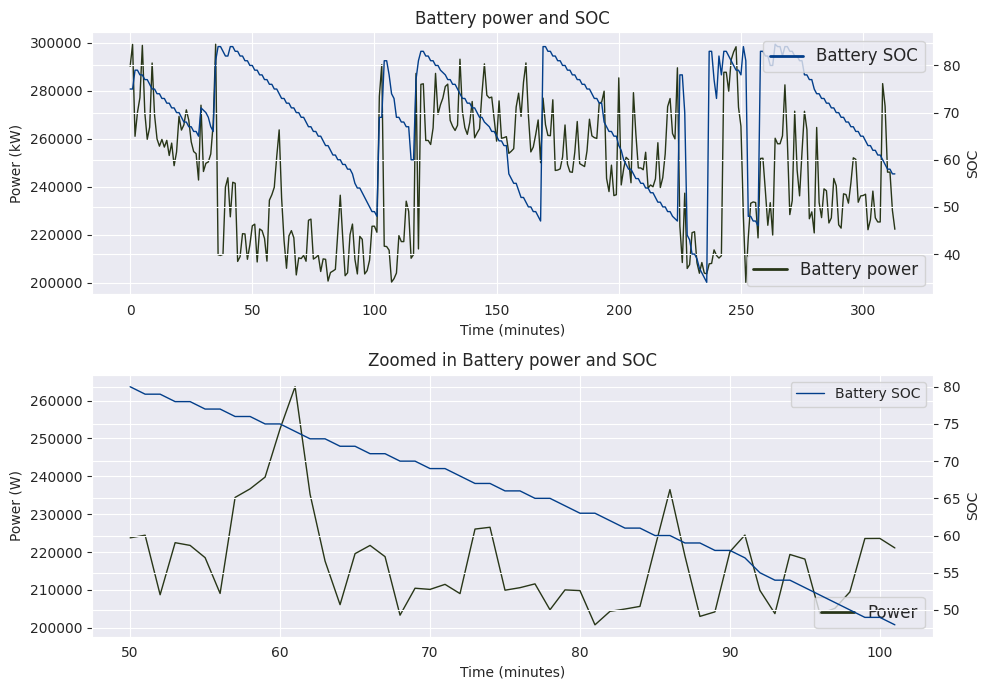

In [13]:
filtered_data = dataset[(dataset["Power"]<300000) & (dataset["Power"]>200000)].copy()
filtered_data.reset_index(drop=True, inplace=True)

sns.set_style('darkgrid')
fig, axes = plt.subplots(2, 1, figsize=(10, 7))
sns.lineplot(filtered_data["Power"], label='Battery power', alpha=1, linewidth=1, color='#283618', ax=axes[0])
axes[0].set_title('Battery power and SOC')
axes[0].set_xlabel('Time (minutes)')  # Setting X-axis label
axes[0].set_ylabel('Power (kW)')  # Setting Y-axis label
ax0_twin = axes[0].twinx()
ax0_twin.set_ylabel('SOC')  # Setting Y-axis label
sns.lineplot(filtered_data["AvgSOC"], label='Battery SOC', alpha=1, linewidth=1, color='#023E8A', ax=ax0_twin)
axes[0].legend()
legend1 = axes[0].legend(loc='lower right', fontsize='large')  # Legend with increased size
legend2 = ax0_twin.legend(loc='upper right', fontsize='large')  # Legend with increased size
for legobj in legend1.legendHandles:
    legobj.set_linewidth(2.0)  # Increase the linewidth in the legend
for legobj in legend2.legendHandles:
    legobj.set_linewidth(2.0)  # Increase the linewidth in the legend

sns.lineplot(filtered_data["Power"][50:102], label='Power', alpha=1, linewidth=1, color='#283618', ax=axes[1])
axes[1].set_title('Zoomed in Battery power and SOC')
axes[1].set_xlabel('Time (minutes)')  # Setting X-axis label
axes[1].set_ylabel('Power (W)')  # Setting Y-axis label
ax1_twin = axes[1].twinx()
ax1_twin.set_ylabel('SOC')  # Setting Y-axis label
sns.lineplot(filtered_data["AvgSOC"][50:102], label='Battery SOC', alpha=1, linewidth=1, color='#023E8A', ax=ax1_twin)
# axes[1].legend(fontsize='large', loc='lower left')
# ax1_twin.legend(fontsize='large')
legend1 = axes[1].legend(loc='lower right', fontsize='large')  # Legend with increased size
legend2 = ax1_twin.legend(loc='upper right', fontsize='large')  # Legend with increased size
for legobj in legend1.legendHandles:
    legobj.set_linewidth(2.0)  # Increase the linewidth in the legend
for legobj in legend2.legendHandles:
    legobj.set_linewidth(2.0)  # Increase the linewidth in the legend


plt.tight_layout()
plt.legend()
plt.show()

/tmp/ipykernel_170260/1017209712.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in legend1.legendHandles:
/tmp/ipykernel_170260/1017209712.py:27: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in legend2.legendHandles:


(array([ 9000., 10000., 11000., 12000., 13000., 14000., 15000., 16000.,
        17000., 18000., 19000.]),
 [Text(9000.0, 0, '9000'),
  Text(10000.0, 0, '10000'),
  Text(11000.0, 0, '11000'),
  Text(12000.0, 0, '12000'),
  Text(13000.0, 0, '13000'),
  Text(14000.0, 0, '14000'),
  Text(15000.0, 0, '15000'),
  Text(16000.0, 0, '16000'),
  Text(17000.0, 0, '17000'),
  Text(18000.0, 0, '18000'),
  Text(19000.0, 0, '19000')])

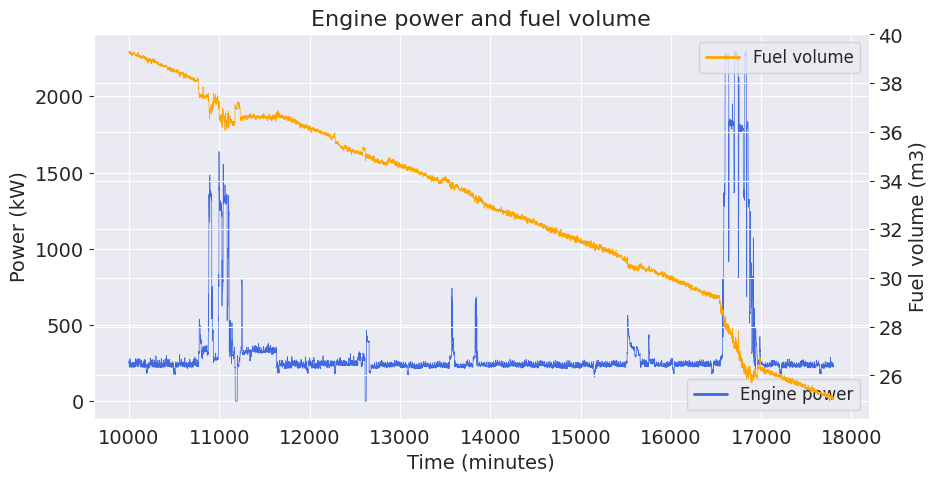

In [14]:
# Proof of correlation between fuel consumption rate and load power
engine_noise_start_point = 10000
engine_noise_end_point = 17800
# (engine_and_fuel_df["total_load"].loc[engine_noise_start_point:engine_noise_end_point]).plot()
# engine_and_fuel_df["total_vol"].loc[engine_noise_start_point:engine_noise_end_point].plot()

sns.set_style('darkgrid')
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
sns.lineplot(engine_and_fuel_df["total_load"].loc[engine_noise_start_point:engine_noise_end_point],
             label='Engine power', alpha=1, linewidth=0.5, color='royalblue', ax=axes)
axes.set_title('Engine power and fuel volume', fontsize=16)
axes.set_xlabel('Time (minutes)', fontsize=14)  # Setting X-axis label
axes.set_ylabel('Power (kW)', fontsize=14)  # Setting Y-axis label
axes.tick_params(axis='x', labelsize=14)
axes.tick_params(axis='y', labelsize=14)
ax0_twin = axes.twinx()
ax0_twin.tick_params(axis='x', labelsize=14)
ax0_twin.tick_params(axis='y', labelsize=14)
ax0_twin.set_ylabel('Fuel volume (m3)', fontsize=14)  # Setting Y-axis label
sns.lineplot(engine_and_fuel_df["total_vol"].loc[engine_noise_start_point:engine_noise_end_point],
             label='Fuel volume', alpha=1, linewidth=0.5, color='orange', ax=ax0_twin)
axes.legend()
legend1 = axes.legend(loc='lower right', fontsize='large')  # Legend with increased size
legend2 = ax0_twin.legend(loc='upper right', fontsize='large')  # Legend with increased size
for legobj in legend1.legendHandles:
    legobj.set_linewidth(2.0)  # Increase the linewidth in the legend
for legobj in legend2.legendHandles:
    legobj.set_linewidth(2.0)  # Increase the linewidth in the legend

plt.xticks(fontsize=14)

/tmp/ipykernel_170260/2093092775.py:21: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in legend1.legendHandles:
/tmp/ipykernel_170260/2093092775.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in legend2.legendHandles:
/tmp/ipykernel_170260/2093092775.py:38: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in legend1.legendHandles:


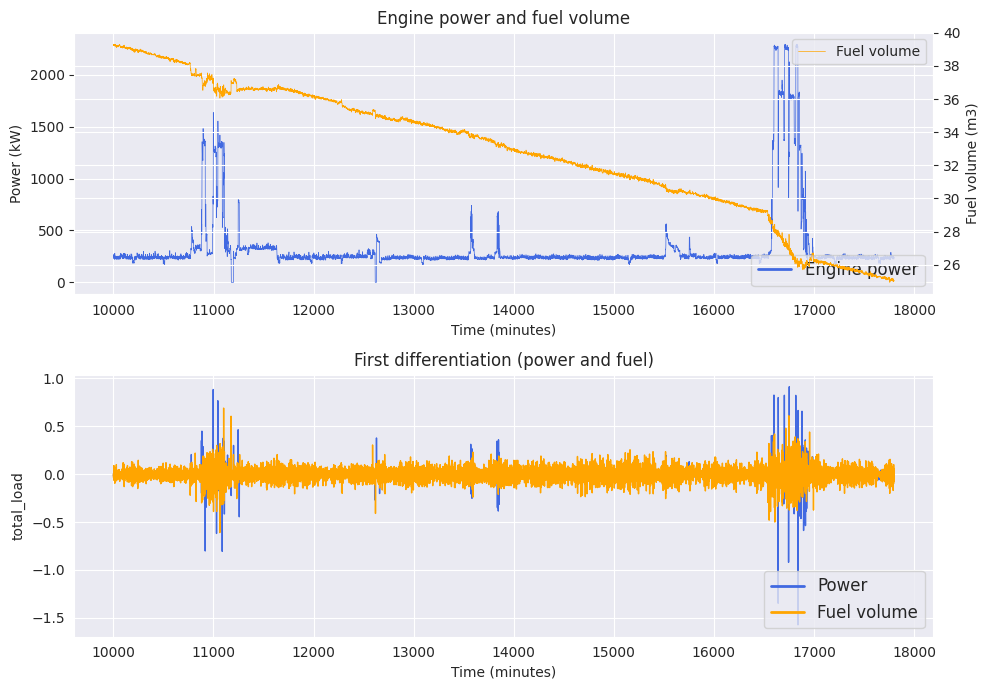

In [15]:
# Proof of correlation between fuel consumption rate and load power
engine_noise_start_point = 10000
engine_noise_end_point = 17800
# (engine_and_fuel_df["total_load"].loc[engine_noise_start_point:engine_noise_end_point]).plot()
# engine_and_fuel_df["total_vol"].loc[engine_noise_start_point:engine_noise_end_point].plot()

sns.set_style('darkgrid')
fig, axes = plt.subplots(2, 1, figsize=(10, 7))
sns.lineplot(engine_and_fuel_df["total_load"].loc[engine_noise_start_point:engine_noise_end_point],
             label='Engine power', alpha=1, linewidth=0.5, color='royalblue', ax=axes[0])
axes[0].set_title('Engine power and fuel volume')
axes[0].set_xlabel('Time (minutes)')  # Setting X-axis label
axes[0].set_ylabel('Power (kW)')  # Setting Y-axis label
ax0_twin = axes[0].twinx()
ax0_twin.set_ylabel('Fuel volume (m3)')  # Setting Y-axis label
sns.lineplot(engine_and_fuel_df["total_vol"].loc[engine_noise_start_point:engine_noise_end_point],
             label='Fuel volume', alpha=1, linewidth=0.5, color='orange', ax=ax0_twin)
axes[0].legend()
legend1 = axes[0].legend(loc='lower right', fontsize='large')  # Legend with increased size
legend2 = ax0_twin.legend(loc='upper right', fontsize='large')  # Legend with increased size
for legobj in legend1.legendHandles:
    legobj.set_linewidth(2.0)  # Increase the linewidth in the legend
for legobj in legend2.legendHandles:
    legobj.set_linewidth(2.0)  # Increase the linewidth in the legend


sns.lineplot(engine_and_fuel_df["total_load"].loc[engine_noise_start_point:engine_noise_end_point].diff()/1000,
             label='Power', alpha=1, linewidth=1, color='royalblue', ax=axes[1])
axes[1].set_title('First differentiation (power and fuel)')
axes[1].set_xlabel('Time (minutes)')  # Setting X-axis label

sns.lineplot(engine_and_fuel_df["total_vol"].loc[engine_noise_start_point:engine_noise_end_point].diff(),
             label='Fuel volume', alpha=1, linewidth=1, color='orange', ax=axes[1])
# axes[1].legend(fontsize='large', loc='lower left')
# ax1_twin.legend(fontsize='large')
legend1 = axes[1].legend(loc='lower right', fontsize='large')  # Legend with increased size
# legend2 = ax1_twin.legend(loc='upper right', fontsize='large')  # Legend with increased size
for legobj in legend1.legendHandles:
    legobj.set_linewidth(2.0)  # Increase the linewidth in the legend
# for legobj in legend2.legendHandles:
#     legobj.set_linewidth(2.0)  # Increase the linewidth in the legend


plt.tight_layout()
plt.legend()
plt.show()

# (engine_and_fuel_df["total_load"].loc[engine_noise_start_point:engine_noise_end_point].diff()/1000).plot()
# engine_and_fuel_df["total_vol"].loc[engine_noise_start_point:engine_noise_end_point].diff().plot()

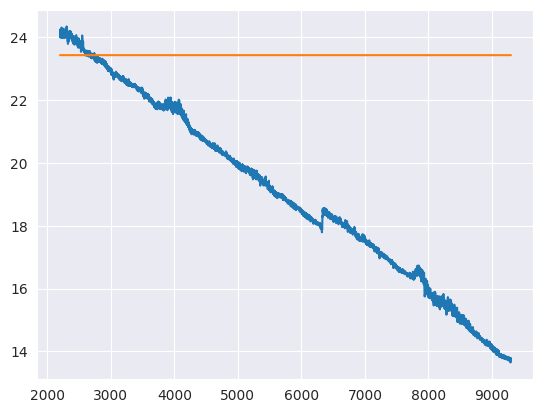

In [16]:
noise_start_point = 2200
noise_end_point = 9300
fuel_data = engine_and_fuel_df["total_vol"][noise_start_point:noise_end_point]
load_data = engine_and_fuel_df["total_load"][noise_start_point:noise_end_point]
(fuel_data).plot()
plt.plot(load_data.index, np.ones(load_data.shape)*load_data.mean()/10)

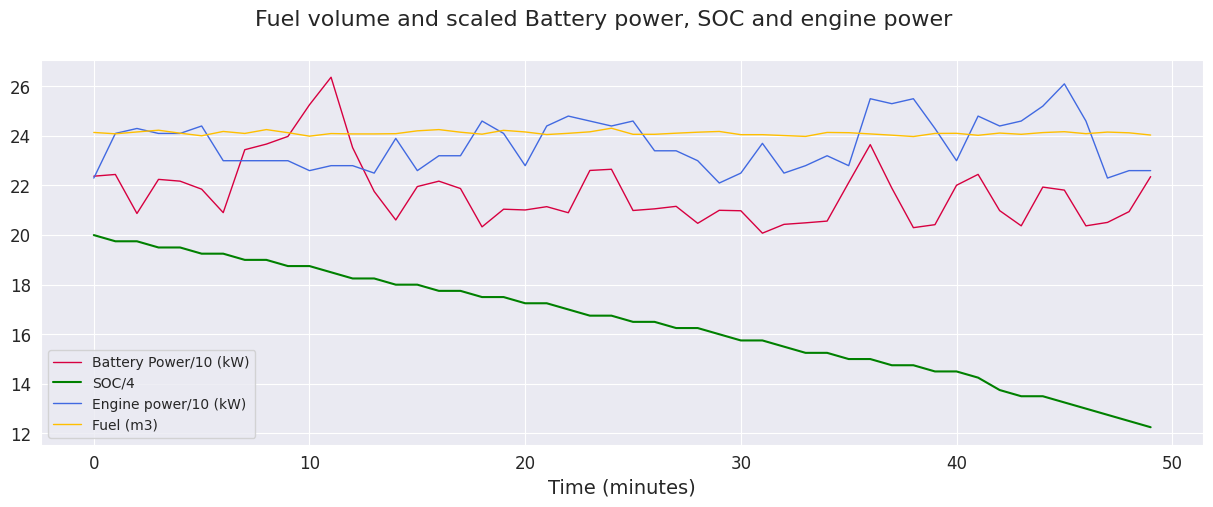

In [17]:
noise_start_point = 2200
noise_end_point = 9300
fuel_data_plot = engine_and_fuel_df["total_vol"][noise_start_point:noise_end_point][:50].reset_index(drop=True)
load_data_plot = engine_and_fuel_df["total_load"][noise_start_point:noise_end_point][:50].reset_index(drop=True)


sns.set_style('darkgrid')
plt.figure(figsize=(15, 5))
plt.suptitle('Fuel volume and scaled Battery power, SOC and engine power', fontsize=16)

(filtered_data["Power"]/10000)[50:100].reset_index(drop=True).plot(color='#D70040', linewidth=1)
(filtered_data["AvgSOC"]/4)[50:100].reset_index(drop=True).plot(color='#008000')


(load_data_plot/10).plot(color='royalblue', linewidth=1)

# plt.plot(load_data.index, np.ones(load_data.shape)*load_data.mean()/10, color='black', linewidth=2)

(fuel_data_plot).plot(color='#FFBF00', linewidth=1)

# Customizing the plot
plt.xlabel('Time (minutes)', fontsize=14)
plt.ylabel('', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(["Battery Power/10 (kW)", "SOC/4", "Engine power/10 (kW)", "Fuel (m3)"])

<Axes: >

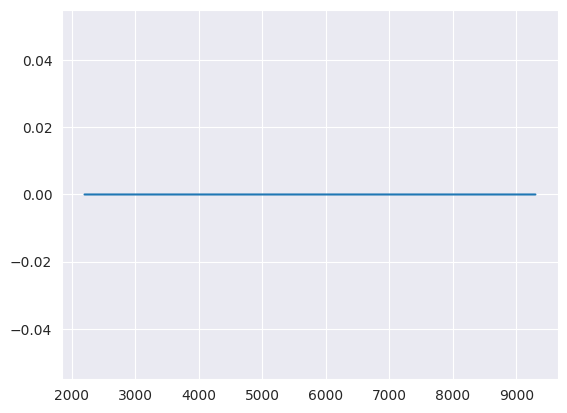

In [18]:
# Battery is not used at all
battery_data.loc[fuel_data.index, "AvgSOC"].plot()

In [19]:
fuel_consumption_mean = fuel_data.diff().mean()
load_data_mean = load_data.mean()
print(fuel_consumption_mean)
print(load_data_mean)

-0.0014664037188336385
234.32014084507043


In [20]:
MAX_SOC = 85
MIN_SOC = 30
AVAILABLE_SOC = 55
available_battery_power_minutes = int(np.floor(np.abs(AVAILABLE_SOC / SOC_fall_rate)))
battery_cycle = int(available_battery_power_minutes*2)
total_trip_length = len(fuel_data)
possible_battery_cycles = int(np.floor(total_trip_length/battery_cycle))

In [21]:
tmp = fuel_data.copy()
tmp.reset_index(drop=True, inplace=True)

fuel_consumption_rate = tmp.diff()

for i in range(possible_battery_cycles):
    battery_only_start_index = i*battery_cycle
    battery_only_end_index = i*battery_cycle+available_battery_power_minutes
    engine_only_start_index = i*battery_cycle+available_battery_power_minutes
    engine_only_end_index = i*battery_cycle+available_battery_power_minutes*2
    tmp.loc[battery_only_start_index:battery_only_end_index] = tmp.loc[battery_only_start_index]
    prev = tmp.loc[battery_only_end_index]
    for j in range(engine_only_start_index, engine_only_end_index+1):
        tmp.loc[j] = prev + fuel_consumption_rate.loc[j]
        prev = tmp.loc[j]

engine_only_start_index = i*battery_cycle+available_battery_power_minutes
engine_only_end_index = tmp.shape[0]
for j in range(engine_only_start_index, engine_only_end_index):
    tmp.loc[j] = prev + fuel_consumption_rate.loc[j]
    prev = tmp.loc[j]

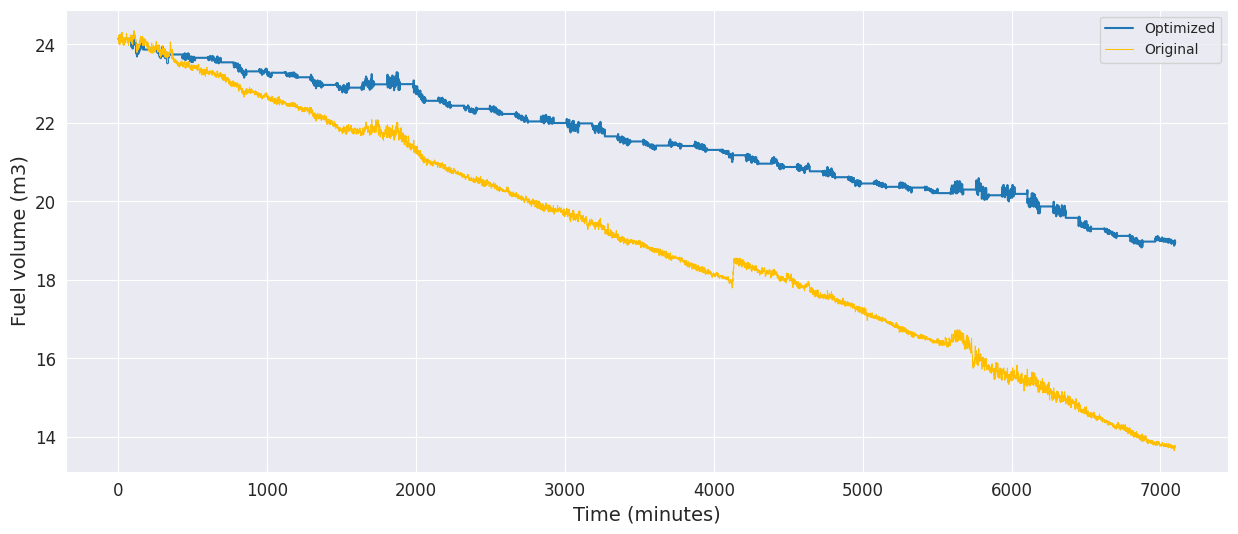

In [22]:
# Proof that the fuel consumption increases with the engine power

sns.set_style('darkgrid')
plt.figure(figsize=(15, 6))

tmp.plot().plot(color='royalblue', linewidth=0.75)
fuel_data.reset_index(drop=True).plot(color='#FFBF00', linewidth=0.75)

# Customizing the plot
plt.xlabel('Time (minutes)', fontsize=14)
plt.ylabel('Fuel volume (m3)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(["Optimized", "Original"])

In [23]:
original_fuel_consumption = fuel_data.max()-fuel_data.min()
optimized_fuel_consumption = tmp.max()-tmp.min()

print(f"The original fuel consumption is {original_fuel_consumption}")
print(f"The optimized fuel consumption is {optimized_fuel_consumption}")
print(f"Saved {original_fuel_consumption - optimized_fuel_consumption}")

The original fuel consumption is 10.694999999999999
The optimized fuel consumption is 5.4200000000000195
Saved 5.274999999999979


# Misc Battery

In [10]:
import math

# Initialize variables to keep track of the start and end indices of the current time series
start_index = None
end_index = None
currents = battery["PACK1_CRIDATA_CURR"]
socs = battery["PACK1_CRIDATA_SOC"]
voltages = battery["PACK1_CRIDATA_AVG_CELL_VOL"]
currents_list = []
socs_list = []
voltages_list = []

for i, value in enumerate(currents):
    if value == 0:
        if start_index is not None:
            # If we've already encountered a start index, this zero indicates the end of the time series
            end_index = i
            if start_index < end_index:
                # Extract the time series from start_index to end_index (inclusive)
                current_segment = currents[start_index:end_index+1]
                soc_segment = socs[start_index:end_index+1]
                voltage_segment = voltages[start_index:end_index+1]
                if not any(math.isnan(x) for x in current_segment):
                    # Check if there are no NaN values in the time series
                    currents_list.append(current_segment)
                    socs_list.append(soc_segment)
                    voltages_list.append(voltage_segment)
            # Reset start and end indices for the next time series
            start_index = None
            end_index = None
    elif start_index is None:
        # If we encounter a non-zero value and haven't yet found a start index, this is the start of a time series
        start_index = i

# Print the identified time series
# for i, currents in enumerate(currents_list):
#     print(f"Time Series {i + 1}: {currents}")

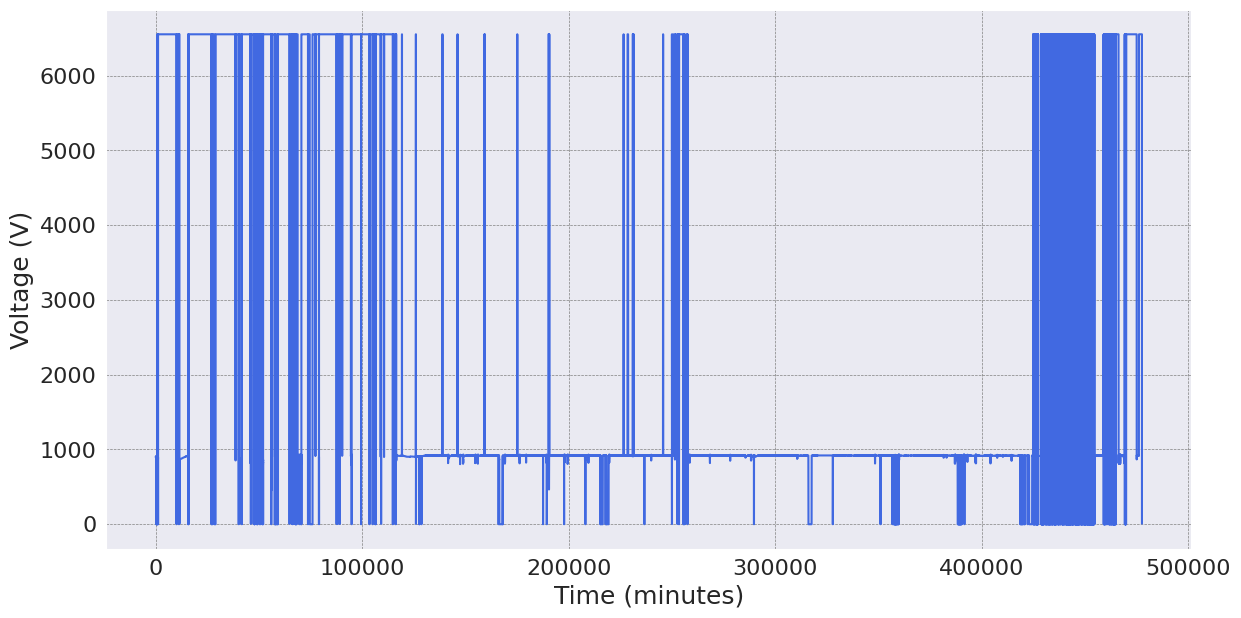

In [88]:
sns.set_style("darkgrid")
plt.figure(figsize=(14, 7))
sns.lineplot(battery["Voltage"], color="royalblue")

# Customizing the plot
plt.xlabel('Time (minutes)', fontsize=18)
plt.ylabel('Voltage (V)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(color='gray', linestyle='--', linewidth=0.5)

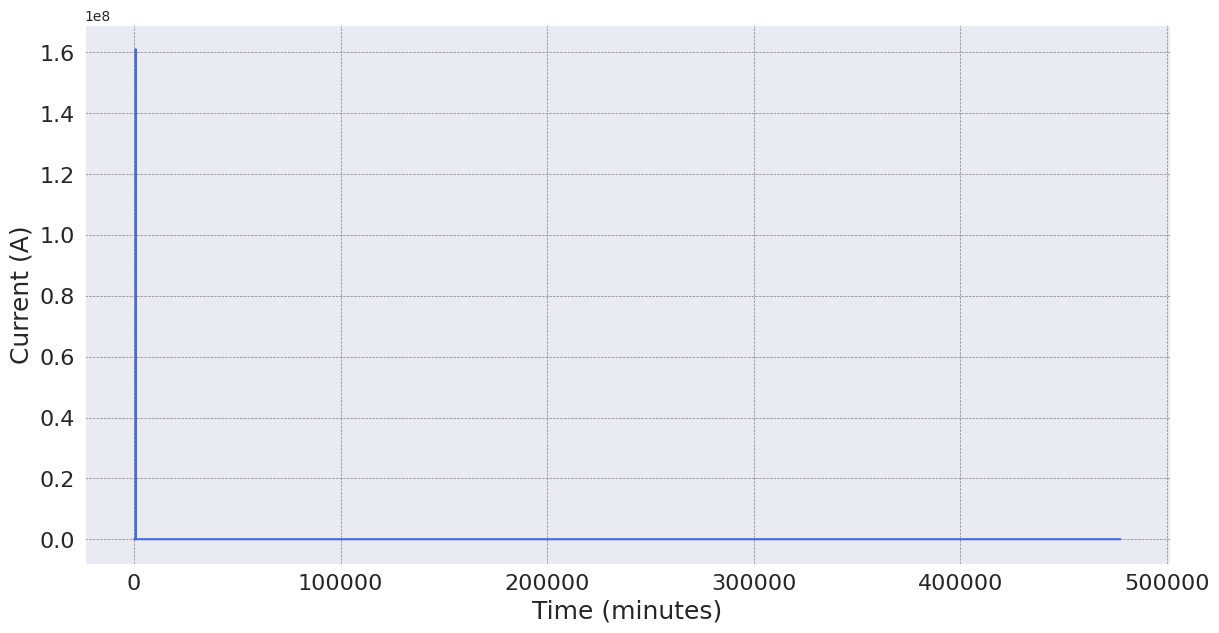

In [89]:
sns.set_style("darkgrid")
plt.figure(figsize=(14, 7))
sns.lineplot(battery["Current"], color="royalblue")

# Customizing the plot
plt.xlabel('Time (minutes)', fontsize=18)
plt.ylabel('Current (A)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(color='gray', linestyle='--', linewidth=0.5)

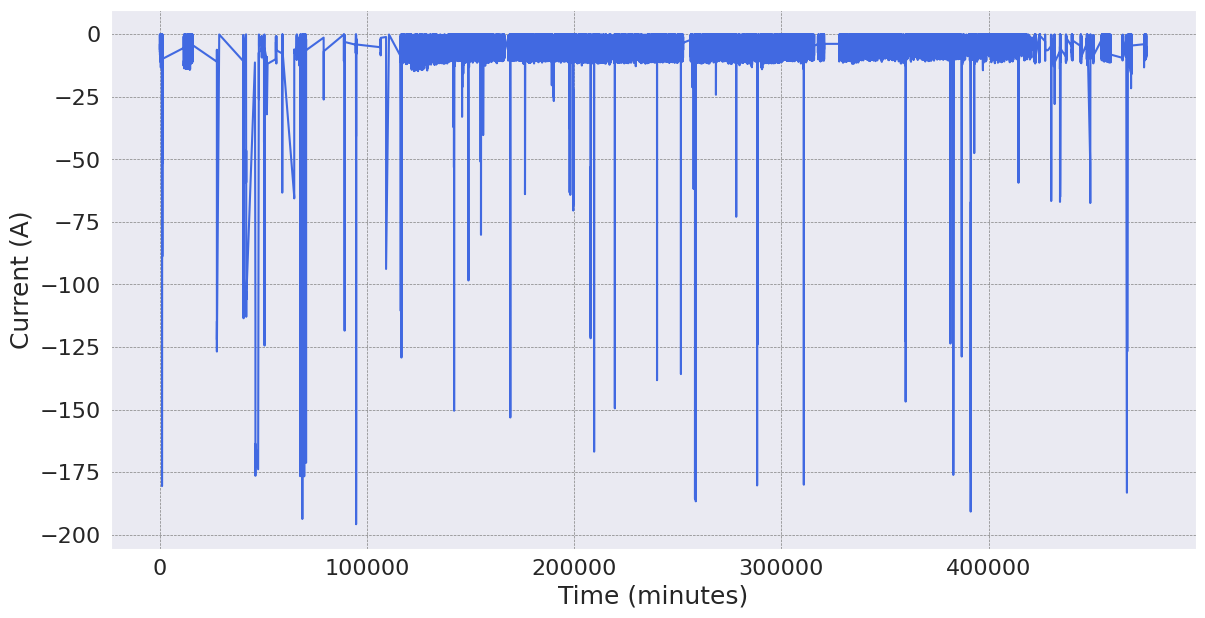

In [90]:
op_discharge_data = battery[(battery["Current"]<0) & (battery["Current"]>-200)]

sns.set_style("darkgrid")
plt.figure(figsize=(14, 7))
sns.lineplot(op_discharge_data["Current"], color="royalblue")

# Customizing the plot
plt.xlabel('Time (minutes)', fontsize=18)
plt.ylabel('Current (A)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(color='gray', linestyle='--', linewidth=0.5)

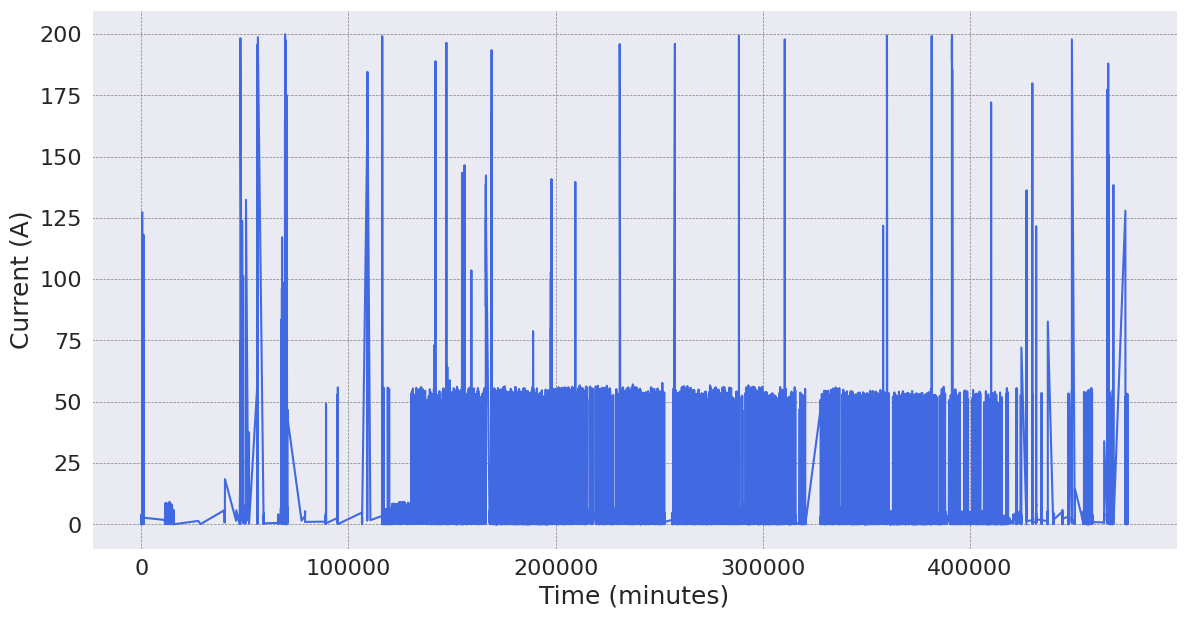

In [91]:
op_charge_data = battery[(battery["Current"]>0) & (battery["Current"]<200)]

sns.set_style("darkgrid")
plt.figure(figsize=(14, 7))
sns.lineplot(op_charge_data["Current"], color="royalblue")

# Customizing the plot
plt.xlabel('Time (minutes)', fontsize=18)
plt.ylabel('Current (A)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(color='gray', linestyle='--', linewidth=0.5)

In [125]:
op_discharge_data = battery[(battery["Current"]<0) & (battery["Current"]>-200)]
op_discharge_current = op_discharge_data.Current
op_discharge_voltage = op_discharge_data.Voltage
op_discharge_soc = op_discharge_data.AVG_PACK_SOC

op_charge_data = battery[(battery["Current"]>0) & (battery["Current"]<200)]
op_charge_current = op_charge_data.Current
op_charge_voltage = op_charge_data.Voltage

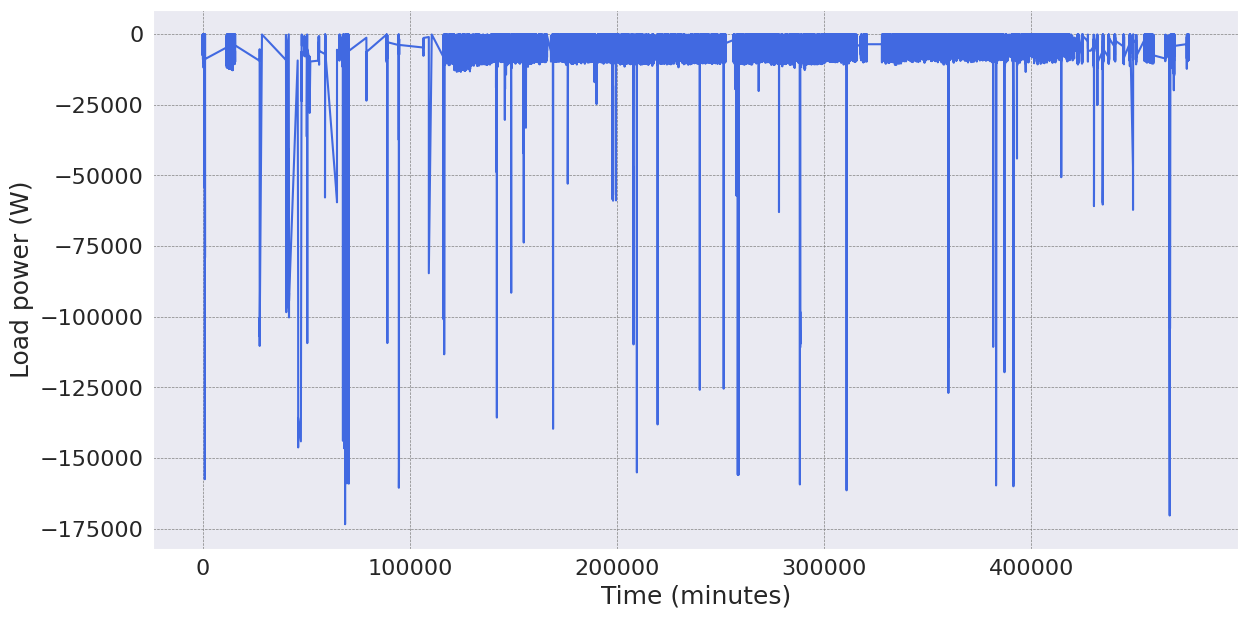

In [126]:
sns.set_style("darkgrid")
plt.figure(figsize=(14, 7))
sns.lineplot(op_discharge_data["Current"] * op_discharge_data["Voltage"], color="royalblue")

# Customizing the plot
plt.xlabel('Time (minutes)', fontsize=18)
plt.ylabel('Load power (W)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(color='gray', linestyle='--', linewidth=0.5)